In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asl-fingerspelling/supplemental_metadata.csv
/kaggle/input/asl-fingerspelling/character_to_prediction_index.json
/kaggle/input/asl-fingerspelling/train.csv
/kaggle/input/asl-fingerspelling/supplemental_landmarks/371169664.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/369584223.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1682915129.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/775880548.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2100073719.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1650637630.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1471096258.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/86446671.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/897287709.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/333606065.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2057261717.parquet
/kaggle/inpu

In [28]:
!pip install mediapipe

In [29]:
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe
import matplotlib
import matplotlib.pyplot as plt
import random


from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from matplotlib import animation,rc



In [30]:
df = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')

In [31]:
df.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


In [32]:
# Fetching Sequence_id,file_id,phrase from the first row
sequence_id, file_id, phrase = df.iloc[0][['sequence_id','file_id','phrase']]
print(f"sequence_id:{sequence_id}, file_id:{file_id}, phrase:{phrase}")

sequence_id:1816796431, file_id:5414471, phrase:3 creekhouse


In [33]:
# Fetch data from parquet file
sample_sequence_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/train_landmarks/{str(file_id)}.parquet",
    filters=[[('sequence_id', '=', sequence_id)],]).to_pandas()
print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))

Full sequence dataset shape is (123, 1630)


In [34]:
sample_sequence_df.head()

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,2,0.711059,0.700858,0.706272,0.693285,0.700825,0.703319,0.711549,0.615606,0.715143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,3,0.712799,0.702518,0.707840,0.694899,0.702445,0.704794,0.712483,0.625044,0.715677,...,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282
1816796431,4,0.712349,0.705451,0.709918,0.696006,0.705180,0.706928,0.712685,0.614356,0.714875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Function to create animation form images

matplotlib.rcParams['animation.embed_limit'] = 2*128
matplotlib.rcParams['savefig.pad_inches'] =0
rc('animation', html ='jshtml')


def create_animation(images):
    fig = plt.figure(figsize=(16,9))
    ax = plt.Axes(fig,[0.,0.,1.,1.])
    fig.add_axes(ax)
    im =ax.imshow(images[0],cmap='gray')
    
    def animate_func(i):
        im.set_array(images[i])
        
        return [im]
    
    return animation.FuncAnimation(fig,animate_func, frames= len(images), interval = 1000/10)

In [36]:

mp_pose = mediapipe.solutions.pose
mp_hands = mediapipe.solutions.hands
mp_drawing = mediapipe.solutions.drawing_utils 
mp_drawing_styles = mediapipe.solutions.drawing_styles

def get_hands(seq_df):
    images = []
    all_hand_landmarks = []
    for seq_idx in range(len(seq_df)):
        x_hand = seq_df.iloc[seq_idx].filter(regex="x_right_hand.*").values
        y_hand = seq_df.iloc[seq_idx].filter(regex="y_right_hand.*").values
        z_hand = seq_df.iloc[seq_idx].filter(regex="z_right_hand.*").values

        right_hand_image = np.zeros((600, 600, 3))

        right_hand_landmarks = landmark_pb2.NormalizedLandmarkList()
        
        for x, y, z in zip(x_hand, y_hand, z_hand):
            right_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
                right_hand_image,
                right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        x_hand = seq_df.iloc[seq_idx].filter(regex="x_left_hand.*").values
        y_hand = seq_df.iloc[seq_idx].filter(regex="y_left_hand.*").values
        z_hand = seq_df.iloc[seq_idx].filter(regex="z_left_hand.*").values
        
        left_hand_image = np.zeros((600, 600, 3))
        
        left_hand_landmarks = landmark_pb2.NormalizedLandmarkList()
        for x, y, z in zip(x_hand, y_hand, z_hand):
            left_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
                left_hand_image,
                left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        images.append([right_hand_image.astype(np.uint8), left_hand_image.astype(np.uint8)])
        all_hand_landmarks.append([right_hand_landmarks, left_hand_landmarks])
    return images, all_hand_landmarks

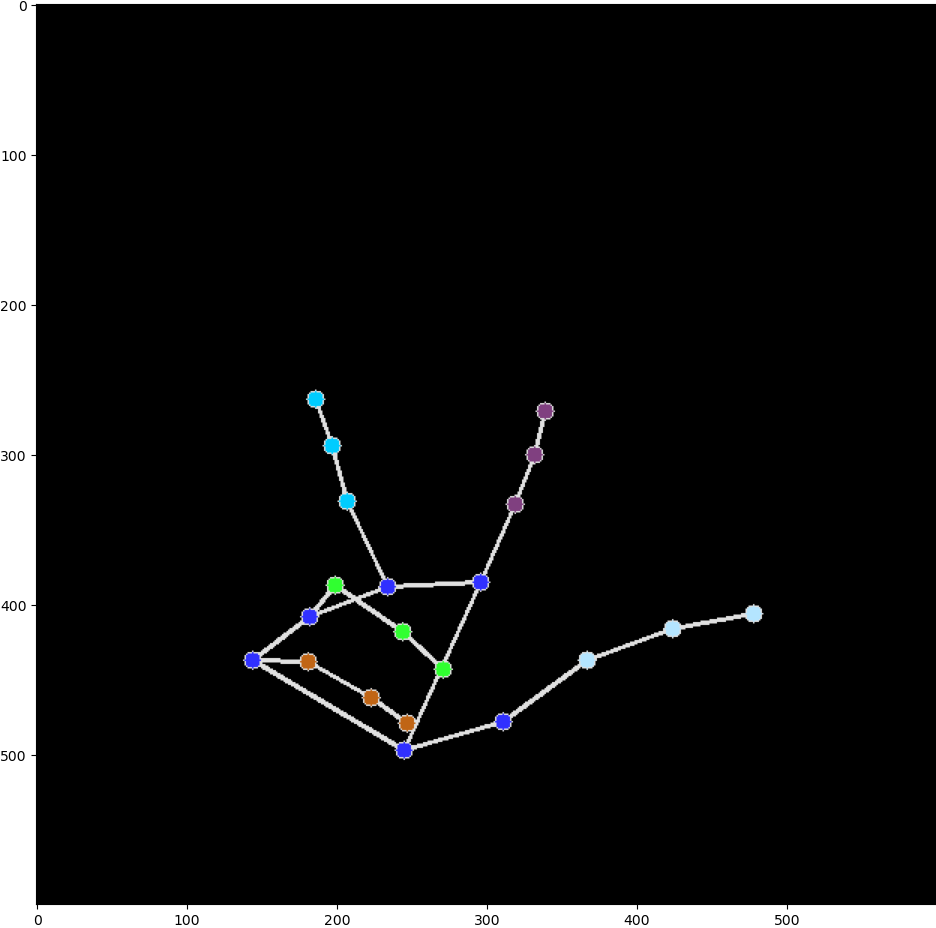

In [37]:
hand_images , hand_landmarks = get_hands(sample_sequence_df)
create_animation(np.array(hand_images)[:, 0])

In [38]:
#  Pose Coordinates for hand movement

LPOSE = [13,15,17,19,21]
RPOSE = [14,16,18,20,22]
POSE = LPOSE + RPOSE

In [39]:
X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

In [40]:
FEATURE_COLUMNS = X+Y+Z

In [41]:
X_IDX = [i for i,col in enumerate(FEATURE_COLUMNS) if 'x_' in col]
Y_IDX = [i for i,col in enumerate(FEATURE_COLUMNS) if'y_' in col]
Z_IDX = [i for i,col in enumerate(FEATURE_COLUMNS) if 'z_' in col]

RHAND_IDX = [i for i,col in enumerate(FEATURE_COLUMNS) if "right" in col]
LHAND_IDX = [i for i,col in enumerate(FEATURE_COLUMNS) if "left" in col]
RPOSE_IDX = [i for i,col in enumerate(FEATURE_COLUMNS) if "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i,col in enumerate(FEATURE_COLUMNS) if 'pose' in col and int(col[-2:]) in LPOSE]

In [42]:
# Set length of frames to 128
FRAME_LEN = 128

# Create directory to store the new data
if not os.path.isdir("preprocessed"):
    os.mkdir("preprocessed")
else:
    shutil.rmtree("preprocessed")
    os.mkdir("preprocessed")

# Loop through each file_id
for file_id in tqdm(df.file_id.unique()):
    # Parquet file name
    pq_file = f"/kaggle/input/asl-fingerspelling/train_landmarks/{file_id}.parquet"
    # Filter train.csv and fetch entries only for the relevant file_id
    file_df = df.loc[df["file_id"] == file_id]
    # Fetch the parquet file
    parquet_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/train_landmarks/{str(file_id)}.parquet",
                              columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()
    # File name for the updated data
    tf_file = f"preprocessed/{file_id}.tfrecord"
    parquet_numpy = parquet_df.to_numpy()
    # Initialize the pointer to write the output of 
    # each `for loop` below as a sequence into the file.
    with tf.io.TFRecordWriter(tf_file) as file_writer:
        # Loop through each sequence in file.
        for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
            # Fetch sequence data
            frames = parquet_numpy[parquet_df.index == seq_id]
            
            # Calculate the number of NaN values in each hand landmark
            r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
            l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
            no_nan = max(r_nonan, l_nonan)
            
            if 2*len(phrase)<no_nan:
                features = {FEATURE_COLUMNS[i]: tf.train.Feature(
                    float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)

  0%|          | 0/68 [00:00<?, ?it/s]

## Get the Save TFRecord files into a list

In [43]:
tf_records = df.file_id.map(lambda x: f'/kaggle/working/preprocessed/{x}.tfrecord').unique()
print(f'List of {len(tf_records)} TFRecord Files. ')

List of 68 TFRecord Files. 


In [44]:
with open("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json","r") as f:
    char_to_num = json.load(f)
    
#     Add pad_token, start pointer and end pointer to the dict

pad_token = 'P'
start_token ='<'
end_token = '>'
pad_token_idx = 59
start_token_idx = 60
end_token_idx=61

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}

In [45]:
def resize_pad(x):
    if(tf.shape(x))[0] < FRAME_LEN:
        x = tf.pad(x,([[0,FRAME_LEN-tf.shape(x)[0]],[0,0],[0,0]]))
    else:
        x = tf.image.resize(x,(FRAME_LEN,tf.shape(x)[1]))
    return x

# detect the dominant hand from the no. of nan values
#  dominant hand will have less nan values

def pre_process(x):
    rhand= tf.gather(x,RHAND_IDX,axis=1)
    lhand = tf.gather(x,LHAND_IDX,axis=1)
    rpose= tf.gather(x,RPOSE_IDX,axis=1)
    lpose=tf.gather(x,LPOSE_IDX,axis=1)
    
    
    # For dominant hand
    if rnans>lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:,0*(len(LHAND_IDX)//3): 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:,1*(len(LHAND_IDX)//3): 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:,2*(len(LHAND_IDX)//3): 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x,hand_y,hand_z],axis=1)
        
        pose_x = pose[:,0*(len(LPOSE_IDX)//3): 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:,1*(len(LPOSE_IDX)//3): 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:,2*(len(LPOSE_IDX)//3): 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([hand_x,hand_y,hand_z],axis=1)
        
    else:
        hand=rhand
        pose=rpose
        
        hand_x = hand[:,0*(len(RHAND_IDX)//3): 1*(len(RHAND_IDX)//3)]
        hand_y = hand[:,1*(len(RHAND_IDX)//3): 2*(len(RHAND_IDX)//3)]
        hand_z = hand[:,2*(len(RHAND_IDX)//3): 3*(len(RHAND_IDX)//3)]
        hand = tf.concat([hand_x[...,tf.newaxis],hand_y[...,tf.newaxis],hand_z[...,tf.newaxis]],axis=1)
        
        pose_x = pose[:,0*(len(RPOSE_IDX)//3): 1*(len(RPOSE_IDX)//3)]
        pose_y = pose[:,1*(len(RPOSE_IDX)//3): 2*(len(RPOSE_IDX)//3)]
        pose_z = pose[:,2*(len(RPOSE_IDX)//3): 3*(len(RPOSE_IDX)//3)]
        pose = tf.concat([hand_x[...,tf.newaxis],hand_y[...,tf.newaxis],hand_z[...,tf.newaxis]],axis=1)
        
        
        x=tf.concat([hand,pose],axis=1)
        x=resize_pad(x)
        
        x = tf.where(tf.math.is_nan(x),tf.zeros_like(x),x)
        x= tf.reshape(x,(FRAME_LEN, len(LHAND_IDX)+ len(LPOSE_IDX)))
        
        return x
        

In [46]:
def decode_fn(recorde_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema['phrase'] = tf.io.FixedLenFeature([],dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes,schema)
    phrase = features['phrase']
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    
    # Transpose to maintain the original shape of landmarks data
    landmarks = tf.transpose(landmarks)
    return landmarks, phrase

In [47]:
table = tf.lookup.StaticHashTable(
    initializer = tf.lookup.KeyValueTensorInitializer(
    keys = list(char_to_num.keys()),
    values = list(char_to_num.values()),
    ),
    default_value = tf.constant(-1),
    name = 'class_weight'
)

def convert_fn(landmarks, phrase):
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    
    phrase = tf.pad(phrase, paddings=[[0,64-tf.shape(phrase)[0]]], mode='CONSTANT',constant_values = pad_token_idx)
    
    return pre_process(landmarks), phrase

In [1]:
batch_size = 64 
train_len = int(0.8* len(tf_records))


train_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
valid_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

# Creating Transformers Model

# Creating Encoding Layer

In [ ]:
# class TokenEmbedding(layers.Layer):
#     def __init_(self, num_vocab=1000, maxlen=100, num_hid=64)

In [ ]:
class TokenEmbedding(layers.Layer):
    def __init_(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen,output_dim=num_hid)
    
    def call(self,x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta = 1)
        positions = self.pos_emb(positions)
        return x+ positions
    

class LandmarkEmbedding(layers.Layer):
    def __init__(self,num_hib=6,maxlen=100):
        super().__init()
        self.conv1 = tf.keras.layers.Conv1D(num_hid, 11, strides=2,padding='same',activation='relu')
        self.conv2 = tf.keras.layers.Conv1D(num_hid,11 strides=2, padding='same',activation='relu')
        self.conv3 = tf.keras.layers.Conv1D(num_hid,11,strides=2,padding='same', activation='relu')
        self.pos_emb = layers.Embedding(input_dim=maxlen,output_dim=num_hid)
        
    def call(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

In [ ]:
# Encoder layer for transformer

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim,num_heads,feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(feed_forward_dim, activation='relu'),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.droput2 =  layers.Dropout(rate)
        
    
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs+attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.layernorm(ffn_output+ trainig = training)
        return self.layernorm2(out1+ffn_output)

In [ ]:
# Decode layer for transformer

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(num_heads= num_heads, key_dim=embed_dim)
        self.enc_att = layers.MultiHeadAttention(num_heads = num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential([
            layers.Dense(feed_forward_dim, activation='relu'),
            layerse.Dense(embed_dim),
        ])
    
    def casual_attention_mask(self,batch_sizem n_dest, n_sec, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >=j - n_src + n_dest
        mask = tf.cast(m,dtype)
        mask = tf.reshape(mask, [1,n_dest,n_src])
        mask = tf.concat([batch_size[..., tf.newaxis],tf.constant([1,1],dtype=tf.int32)],0)
        
        return tf.tile(mask,mult)
    
    
    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size=input_shape[0]
        seq_len = input_shape[1]
        casual_mask = self.casual_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target,target,attention_mask=casual_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training=training))
        enc_out = self.enc_att(target_norm,enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out,training=training+ target_norm))
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training =training))
        
        return ffn_out_norm

In [49]:
class Transfrom(keras.Model):
    def __init__(
    self, 
    num_hid =64,
    num_head = 2..
    num_feed_forward=128,
    source_maxlen=100,
    target_maxlen=100,
    num_layers_enc=4,
    num_layer_dec=1,
    num_classes=60,
    ):
        super().__init()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metric.Mean(name="edit_dist")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec 
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes
        
        self.enc_input = LandmarkEmbedding(num_hid=num_hid,maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(num_vocab = num_classes, maxlen=target_maxlen, num_hid= num_hid)
        self.encoder = keras.Sequential([self.enc_input] + [ TransformerEncoder(num_hid, num_head,num_feed_forward)
                       for _ in range(num_layers_enc)
                            ]
                    )
        for i in range(num_layers_dec):
            setattr(
            self, 
            f"dec_layer_{i}", TransformerDecoder(num_hid, num_head, num_feed_forward),
            )
            
        self.classifier = layer.Dense(num_classes)
        
        def decode(self, enc_out,target,training):
            y = self.dec_input(target)
            for i in range(self.num_layers_dec):
                y = getattr(self, f"dec_layer_{i}")(enc_out,y,training)
            return y
        
        def call(self, inputs ,training):
            source= inputs[0]
            source = inputs[1]
            x = self.encoder(source, training)
            y = self.decode(x,target, training)
            return self.classifier(y)
        
        @property
        def metric(self):
            return [self.loss_metric]
        
        def train_step(self,batch):
            source = batch[0]
            target= batch[1]
            
            input_shape = tf.shape(target)
            batch_size = input_shape[0]
            
            dec_input = target[:,:-1]
            dec_target = target[:,1,:]
            preds = self([source,dec_input])
            one_hot = tf.one_hot(dec_target, depth = self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight = mask)
            
            edit_dist = tf.edit_distance(tf.sparse.from_dense(target), tf.spare.from_denes(tf.cast(tf.argmax(preds,axis=1),tf.int32)))
            edit_dist = tf.reduce_mean(edit_dist)
            self.acc_metric.update_state(edit_dist)
            self.loss_metric.update_state(loss)
            return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}
        
        
        def generate(self, source, target_start_token_idx):
            bs = tf.shape(source)[0]
            enc = self.encoder(source, training=False)
            dec_input = tf.ones((bs,1),dtype=tf.int32)* target_start_token_idx
            dec_logits = []
            for i in range(self.target_maxlen-1):
                dec_out = self.decode(enc, dec_input, training = False)
                logits = self.classifier(dec_out)
                logits = tf.argmax(logits,axis=1, output_type = tf.int32)
                last_logit = logits[:,-1][..., tf.newaxis]
                dec_logits.append(last_logit)
                dec_input = tf.concat([dec_input, last_logit],axis=1)
                
                return dec_input
            
            

SyntaxError: invalid syntax (755573787.py, line 6)

In [ ]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(self,batch,idx_to_token, target_start_token_idx=60, target_end_token_idx=61):
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token
        
    def on_epoch_end(self, epoch,logs=None):
        if epoch%4 !=0:
            return
        source = self.batch[0]
        target = self.batch[1].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text= "".join([self.idx_to_char[_] for _ in target[i,:]])
            prediction = ""
            for idx in preds[i,:]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:   {target_text.replace("-","")}")
            print(f"prediction: {prediction}\n")

## Train The Transformer Model

In [ ]:
batch = next(iter(valid_ds))


idx_to_char = list(char_to_num.keys())
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=char_to_num['<'],target_end_token_indx=char_to_num['>'])


model = Transformer(
    num_hid = 200,
    num_head = 4,
num_feed_forward = 400,
source_maxlen=FRAME_LEN,
target_maxlen=64,
    num_layers_enc = 2,
    num_classes=62
)

loss_fn = tf.keras.losses.CategoricalCrossentropy( from_logits=True, label_something=0.1,)
optimizer = keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn)
history = model.fit(train_ds,validation_data=valid_ds, callback=[display_cb],epochs=13)

# Plotting loss and validation loss

In [ ]:
plt.plot(history.histroy['loss'])
plt.plot(history.history['val_loss'])
plt.legend('training_loss','val_loss')